In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline
%load_ext pycodestyle_magic

Using TensorFlow backend.


In [2]:
v1 = pd.read_csv('example_data_new/v1_obfs.csv')
v2 = pd.read_csv('example_data_new/v2_obfs.csv')
v4 = pd.read_csv('example_data_new/v4_obfs.csv')
v8 = pd.read_csv('example_data_new/v8_obfs.csv')

In [3]:
v = [v1, v2, v4, v8]
v_names = ['v1', 'v2', 'v4', 'v8', 'v11', 'v14', 'v15', 'v19']
sel_columns = [' Meas_5', ' Meas_6', ' Meas_7', ' Meas_8', ' Meas_9', ' Meas_10']
sel_column = [' Meas_5']

### Functions

In [103]:
def sliding_window(data, train_size, test_size, step_size):
    '''sliding window with an intersection between windows
    by size of _step_size_'''
    x, y = [], []
    line_size = data.shape[0]
    for start in range(0, line_size, step_size):
        stop = start + train_test_size
        if stop <= line_size:
            x.append(data[start: start+train_size])
            y.append(data[start+train_size: start+train_size+test_size])
    return np.array(x), np.array(y)


def norm_ts(data):
    """
    scaler ->  TS∈[0,1] .
    """
    scaler = MinMaxScaler(copy=True)
    scaled01 = scaler.fit_transform(data)
    return np.squeeze(scaled01), scaler


def inverse_norm(data, scaler):
    """ inverse scaling
    """
    return scaler.inverse_transform(data)


def train_test_reshape(train_x, test_x):
    """reshape + split train test 50-50"""
    return np.expand_dims(train_x, axis=2), np.expand_dims(test_x, axis=2)


def naive_prediction_mae(x_test, y_test):
    """prediction using last value"""
    naive_pred = 0
    n = x_test.shape[0]
    for i in range(n): 
        naive_pred += np.mean(np.abs(x_test[i, -1] - y_test[i, :]))
    naive_pred /= n
    print ('naive model = {0:0.4f}'.format(naive_pred))
    return None


def model_mae(model, x_test, y_test, scaler, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None


### Parameters of Sliding Window

In [125]:
train_size = 168 * 2
test_size = 24
train_test_size = train_size + test_size
line_size = v1.shape[1]
step_size = 1

### Normalization

In [135]:
data= v1[sel_column].values
train_test_split = int(.75 * v1.shape[0])
train_xy = data[:train_test_split]

test_xy = data[train_test_split:]

train_xy_normed, scaler = norm_ts(train_xy)


train_x, train_y = sliding_window(data=train_xy_normed,
                                  train_size=train_size,
                                  test_size=test_size,
                                  step_size=step_size)

test_x_original, test_y_original = sliding_window(data=np.squeeze(test_xy),
                                  train_size=train_size,
                                  test_size=test_size,
                                  step_size=step_size)


test_x, scaler_test = norm_ts(test_x_original.T)
test_x = test_x.T

train_x, test_x = train_test_reshape(train_x, test_x)
print (train_x.shape, test_x.shape, test_y.shape)

(6205, 336, 1) (1830, 336, 1) (999, 24)


### CNN network

In [127]:

def cnn_model(x_train, y_train, batch_size, epochs=50, n_steps_for_train=train_size):
    
    
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=6, kernel_size=4, input_shape=(input_dim ,1)))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=24, activation='linear'))


    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

In [128]:
model, history = cnn_model(x_train=train_x, y_train=train_y, batch_size=4, epochs=20)

Train on 4343 samples, validate on 1862 samples
Epoch 1/20
 - 1s - loss: 0.0268 - mean_absolute_error: 0.1081 - val_loss: 0.0162 - val_mean_absolute_error: 0.0852
Epoch 2/20
 - 1s - loss: 0.0155 - mean_absolute_error: 0.0836 - val_loss: 0.0143 - val_mean_absolute_error: 0.0782
Epoch 3/20
 - 1s - loss: 0.0133 - mean_absolute_error: 0.0768 - val_loss: 0.0135 - val_mean_absolute_error: 0.0754
Epoch 4/20
 - 1s - loss: 0.0120 - mean_absolute_error: 0.0721 - val_loss: 0.0125 - val_mean_absolute_error: 0.0712
Epoch 5/20
 - 1s - loss: 0.0110 - mean_absolute_error: 0.0684 - val_loss: 0.0119 - val_mean_absolute_error: 0.0685
Epoch 6/20
 - 1s - loss: 0.0102 - mean_absolute_error: 0.0655 - val_loss: 0.0115 - val_mean_absolute_error: 0.0670
Epoch 7/20
 - 1s - loss: 0.0096 - mean_absolute_error: 0.0630 - val_loss: 0.0108 - val_mean_absolute_error: 0.0641
Epoch 8/20
 - 1s - loss: 0.0090 - mean_absolute_error: 0.0608 - val_loss: 0.0105 - val_mean_absolute_error: 0.0630
Epoch 9/20
 - 1s - loss: 0.0085 

### Comparison to Naive model

In [129]:
naive_prediction_mae(x_test=test_x_original, y_test=test_y_original)
model_mae(model, x_test=test_x, y_test=test_y_original,
          scaler=scaler_test, inv_norm=True)


naive model = 1550.1450
current model = 809.2659


In [134]:
test_x.shape, test_x_original.shape, test_y.shape

((1830, 336, 1), (1830, 336), (999, 24))

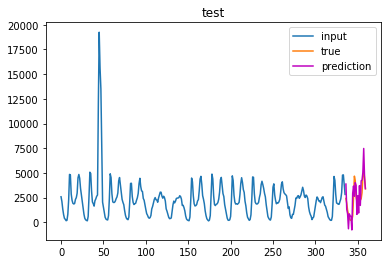

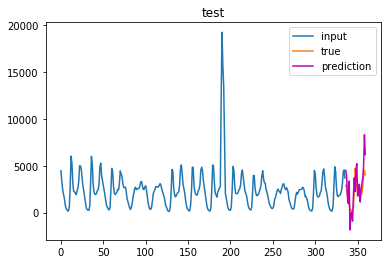

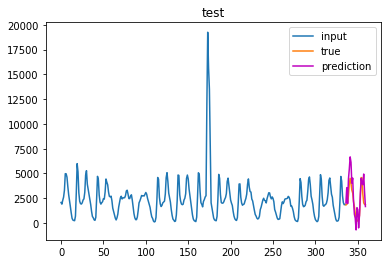

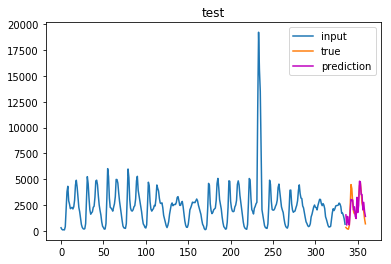

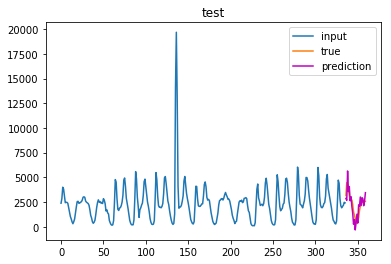

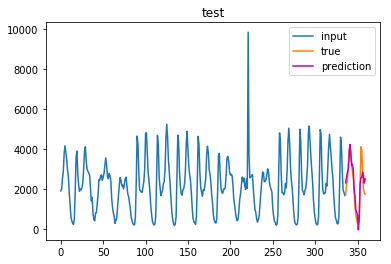

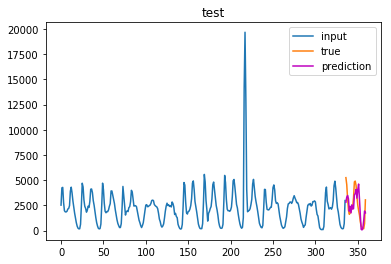

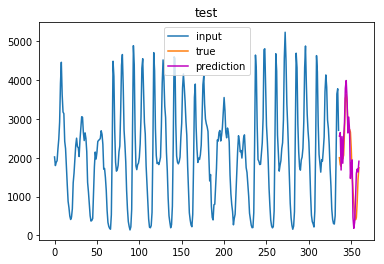

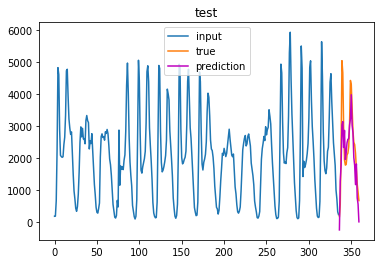

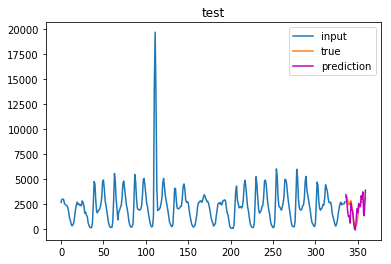

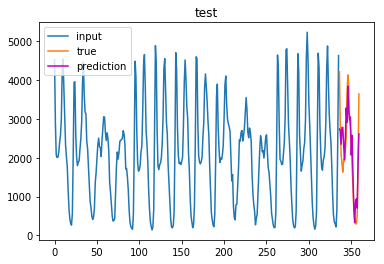

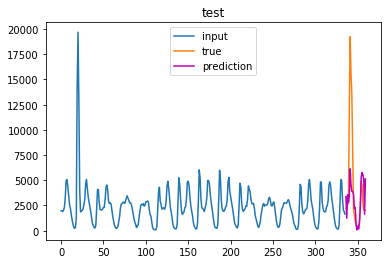

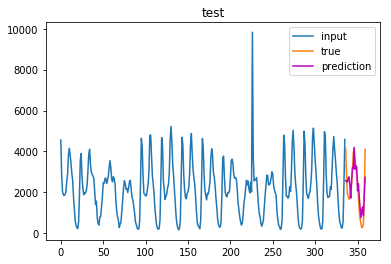

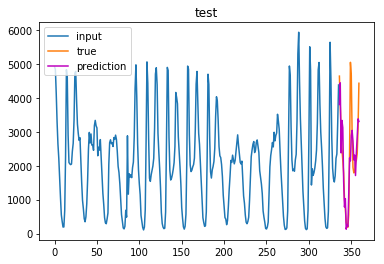

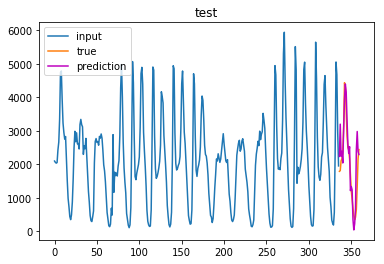

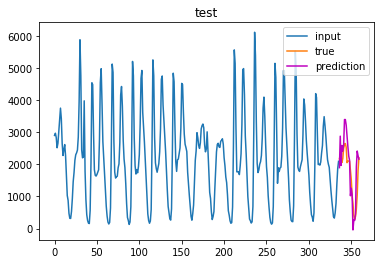

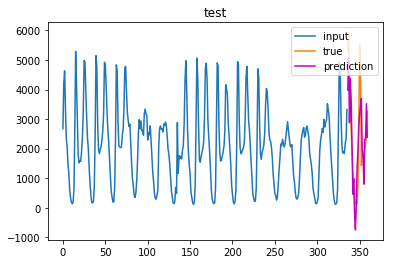

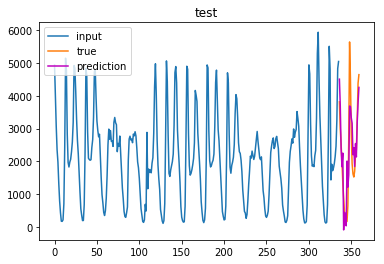

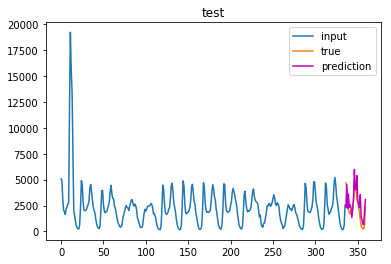

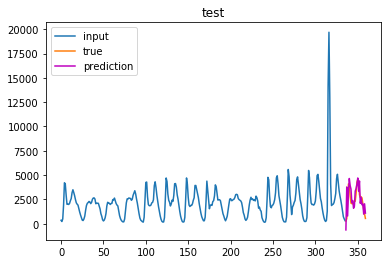

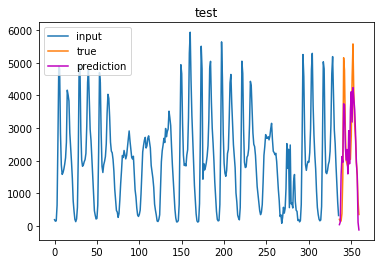

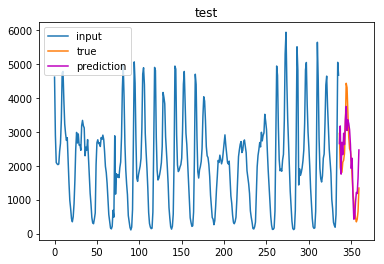

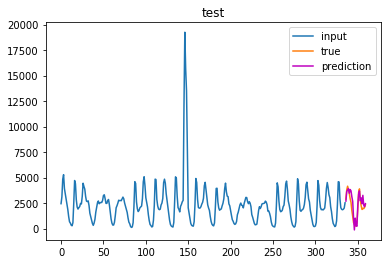

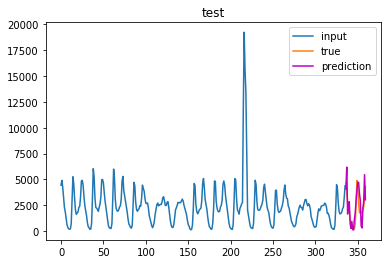

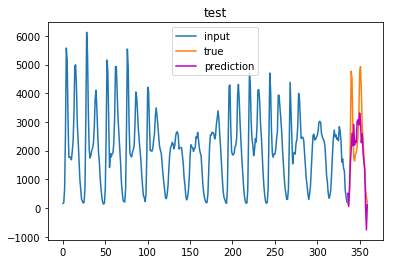

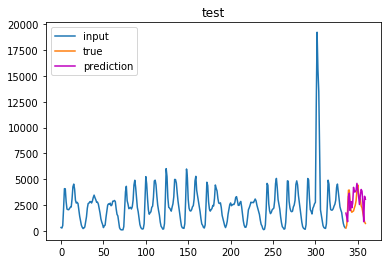

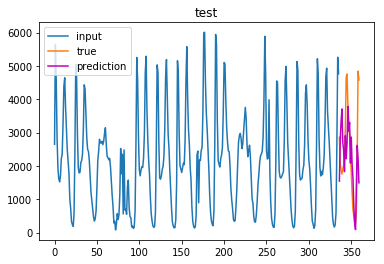

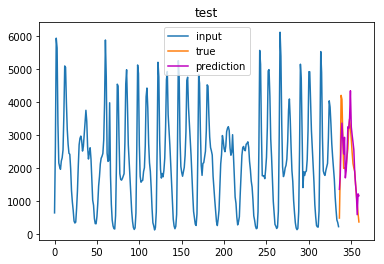

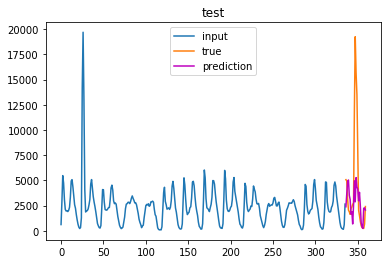

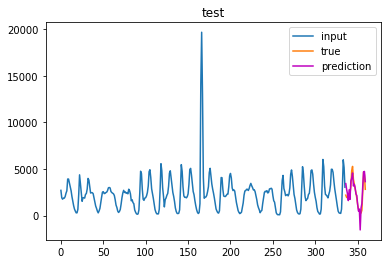

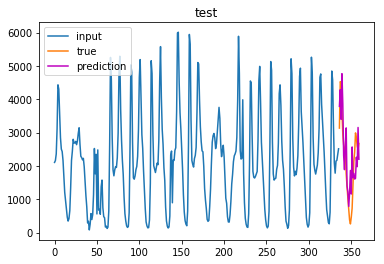

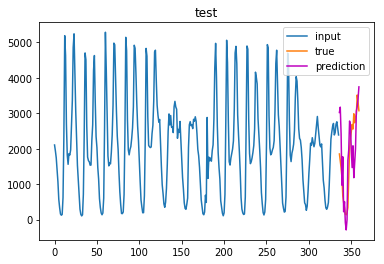

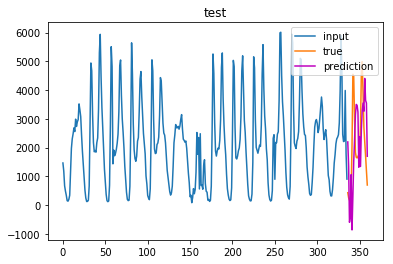

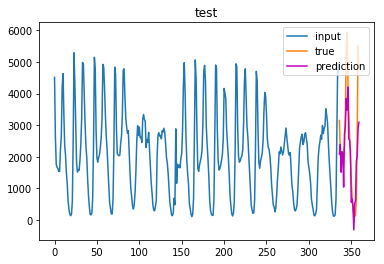

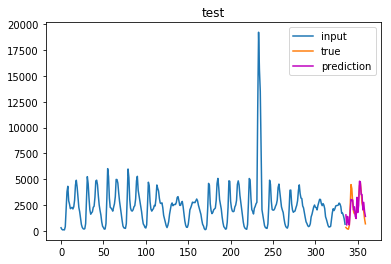

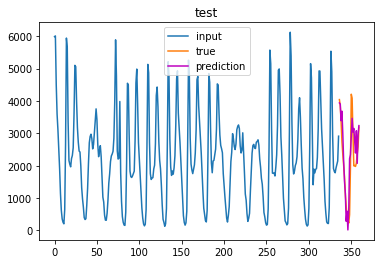

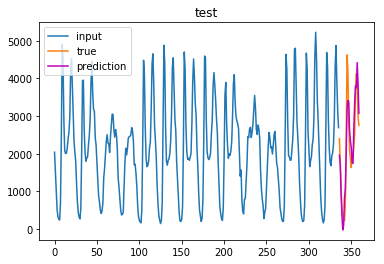

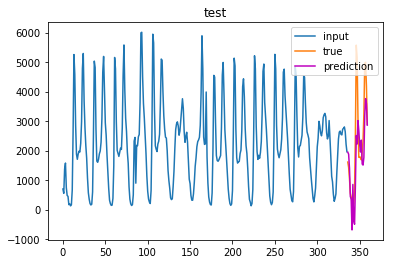

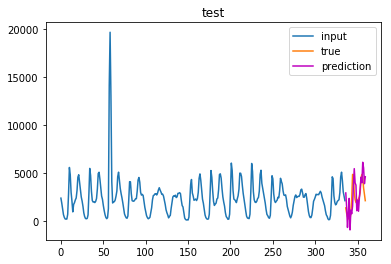

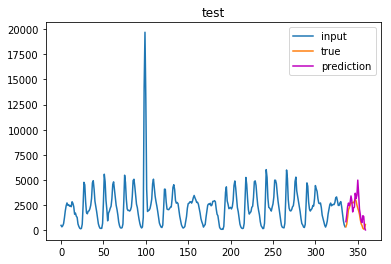

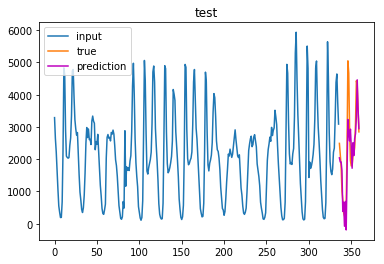

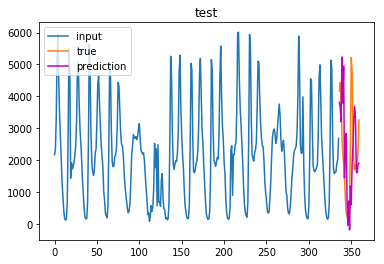

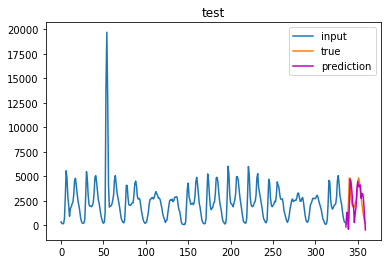

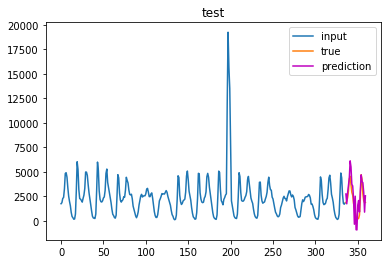

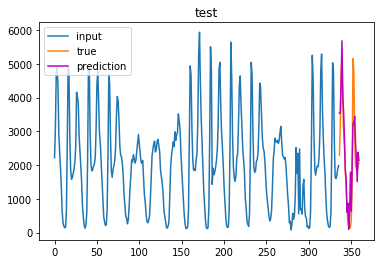

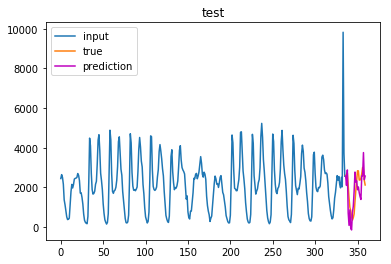

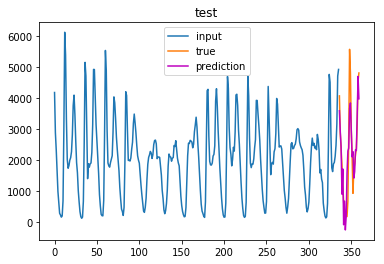

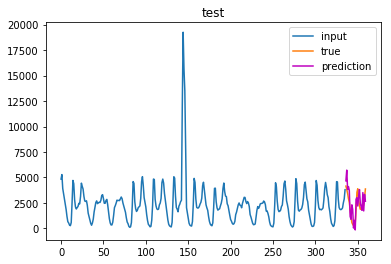

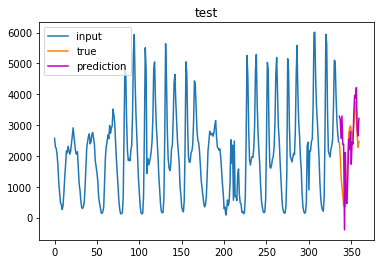

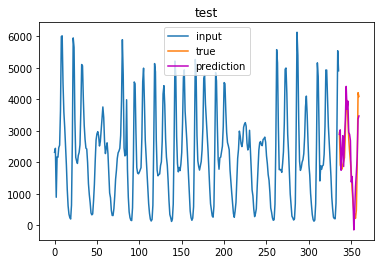

In [136]:
plt.rcParams.update({'figure.max_open_warning': 50})
np.random.seed(seed=123)
pred = model.predict(test_x)
pred = inverse_norm(pred.T, scaler=scaler_test).T
for i in np.random.randint(0, test_x.shape[0], 50):
    plt.figure()
    plt.plot(range(train_size), test_x_original[i], label='input')
    plt.plot(range(train_size, train_size+test_size), test_y_original[i], label='true')
    plt.plot(range(train_size, train_size+test_size), pred[i], c='m', label='prediction')
    plt.title('test')
    plt.legend()

In [236]:

np.random.seed(seed=123)
np.random.randint(0, test_x.shape[0], 30)

array([510, 365, 382, 322,  98,  17, 595, 106, 123, 569, 214,  96, 113,
       638,  47,  73, 544, 224, 111, 409, 339, 253, 420, 608, 208,  68,
       451,   2, 340,  39])

In [260]:
list(range(0,30,3))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]